# Mexican PIB Forecasting

- The data corresponds to the Gross Domestic Product (*Producto Interno Bruto*) in Mexico of the Financial and Insurance Services sector over the last 31 years. 
- Information extracted from the official website of the Mexican Central Bank in combination with INEGI.

## 1. Problem statement

The Financial and Insurance Services sector plays a critical role in Mexico's economy. However, predicting this sector's Gross Domestic Product (GDP) is challenging due to its dependence on various complex economic factors and market fluctuations. Traditional time series models often struggle to capture long-term dependencies and non-linear relationships in economic data. Therefore, this analysis aims to leverage advanced, recurrent neural network architectures, specifically Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU) networks, to model and predict the Mexican GDP of the Financial and Insurance Services sector.

### Contents:
1. [Problem statement](#1.-Problem-statement)
2. [Preprocessing data](#2.-Preprocessing-data)
   1. [Requirements](#Requirements)
   2. [Time series extraction](#Time-series-extraction)
   3. [Tensor definition](#Tensor-definition)
3. [Training](#3.-Training)
   1. [LSTM](#LSTM-architecture)
   2. [GRU](#GRU-architecture)
4. [Results](#4.-Results)
   1. [LSTM](#LSTM)
   2. [GRU](#GRU)
   2. [Visualizations](#Visualizations)

## 2. Preprocessing data

### Requirements

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torchvision.utils as utils
from sklearn.preprocessing import MinMaxScaler

In [2]:
def get_date(epoch_time):
    epoch_time /= 1000
    return time.strftime('%Y-%m-%d', time.gmtime(epoch_time))

In [3]:
def get_labels(df):
    labels = []
    indxs = []
    for i in range(len(df['Time'])):
        if (i%4==0):
            label_str = df['Time'][i][:4]
            labels.append(label_str)
            indxs.append(i)
    return labels, indxs

In [4]:
def memory_cell(ordered_set, time_step):
    features, targets = [], []
    for indx in range(len(ordered_set)-time_step):
        indx_feature = ordered_set[indx:indx+time_step]
        indx_target = ordered_set[indx+1:indx+time_step+1]
        features.append(indx_feature)
        targets.append(indx_target)
    features = np.array(features)
    targets = np.array(targets)
    return torch.tensor(features, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

### Time series extraction

In [5]:
df_data = pd.read_csv('data/Producto-interno-bruto-trimestral.csv', usecols=['GDP', 'Time'])

In [6]:
df_data['Time'] = df_data['Time'].transform(lambda x: get_date(x))
df_data['GDP'] = df_data['GDP'].transform(lambda x: x/1000000000)
df_data = df_data.reindex(columns=['Time','GDP'])

In [7]:
train_size = round(0.7*df_data.shape[0])
train_set = df_data.iloc[:train_size-1] 
test_set = df_data.iloc[train_size:] 

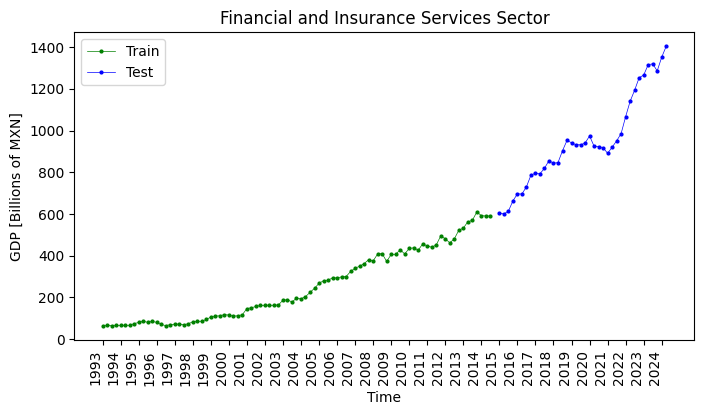

In [8]:
plt.figure(figsize=(8,4))
plt.plot(train_set['GDP'], label='Train', marker='.', markersize='4', linewidth='0.5', color='green')
plt.plot(test_set['GDP'], label='Test', marker='.', markersize='4', linewidth='0.5', color='blue')
plt.title('Financial and Insurance Services Sector')
plt.ylabel('GDP [Billions of MXN]')
labels, indxs = get_labels(df_data)
plt.xticks(indxs, labels, rotation=90, ha="right")
plt.xlabel('Time')
plt.legend() 
plt.show()

### Tensor definition

In [9]:
sc = MinMaxScaler(feature_range=(-1, 1))
data_np = np.array(df_data['GDP'])
data_np = data_np.reshape(-1, 1)
data_scaled = sc.fit_transform(data_np)
data_tensor = sc.inverse_transform(data_scaled)
data_scaled_tensor = torch.tensor(data_scaled, dtype=torch.float32)

In [10]:
train_np = np.array(train_set['GDP'])
train_np = train_np.reshape(-1, 1)
train_set_scaled = sc.fit_transform(train_np)
features_train, targets_train = memory_cell(train_set_scaled, time_step=5)
train_set_tensor = torch.utils.data.TensorDataset(features_train, targets_train)

In [11]:
test_np = np.array(test_set['GDP'])
test_np = test_np.reshape(-1, 1)
test_set_scaled = sc.fit_transform(test_np)
features_test, targets_test = memory_cell(test_set_scaled, time_step=5)
test_set_tensor = torch.utils.data.TensorDataset(features_test, targets_test)

## 3. Training

In [12]:
if torch.cuda.is_available(): 
    dev = "cuda:0"
else: 
    dev = "cpu"

In [13]:
class Learning_class():
    def __init__(self, model):
        self.epochs = 100
        self.device = torch.device(dev)
        self.model = model.to(self.device)
        self.loss_func = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.train_loss_hist = []
        self.test_loss_hist = []
        self.history = []

    def train_model(self):
        for epoch in range(self.epochs):
            train_loss = 0.0
            self.model.train()
            for scaled_batch, target_batch in self.model.train_loader:
                scaled_batch = scaled_batch.to(self.device)
                target_batch = target_batch.to(self.device)
                forecast_batch = self.model(scaled_batch)
                loss = self.loss_func(forecast_batch, target_batch)
                with torch.no_grad():
                    train_loss += loss.item()
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            train_loss /= len(self.model.train_loader)
            
            test_loss = 0.0
            self.model.eval()
            with torch.inference_mode():
                for scaled_batch, target_batch in self.model.test_loader:
                    scaled_batch = scaled_batch.to(self.device)
                    target_batch = target_batch.to(self.device)
                    forecast_batch = self.model(scaled_batch)
                    loss = self.loss_func(forecast_batch, target_batch)
                    with torch.no_grad():
                        test_loss += loss.item()
                test_loss /= len(self.model.test_loader)
            
            print(f"Epoch: {epoch+1} Train loss: {train_loss: .5f} Test loss: {test_loss: .5f}")
            self.train_loss_hist.append(train_loss)
            self.test_loss_hist.append(test_loss)
            
        self.history.append(self.train_loss_hist)
        self.history.append(self.test_loss_hist)
        return self.model, self.history

### LSTM architecture

In [14]:
class LSTM(nn.Module):
    def __init__(self, train_set, test_set):
        self.batch_size = 64
        self.train_loader = torch.utils.data.DataLoader(dataset=train_set_tensor,
                                                        batch_size=self.batch_size,
                                                        shuffle=True)        
        self.test_loader = torch.utils.data.DataLoader(dataset=test_set_tensor,
                                                        batch_size=self.batch_size,
                                                        shuffle=False)        
        super(LSTM, self).__init__()      
        self.lstm_layer_1 = nn.LSTM(input_size=1, hidden_size=64, batch_first=True)
        self.fully_layer_2 = nn.Sequential(nn.Linear(64, 32))
        self.fully_layer_3 = nn.Sequential(nn.Linear(32, 1))

    def forward(self, input_seq):
        out, _ = self.lstm_layer_1(input_seq)
        out = self.fully_layer_2(out)
        out = self.fully_layer_3(out)
        return out

In [15]:
lstm_model = LSTM(train_set_scaled, test_set_scaled)
lstm_learning_model = Learning_class(lstm_model)
lstm_trained_model, lstm_history = lstm_learning_model.train_model()

Epoch: 1 Train loss:  0.55406 Test loss:  0.25459
Epoch: 2 Train loss:  0.47738 Test loss:  0.23918
Epoch: 3 Train loss:  0.47075 Test loss:  0.22574
Epoch: 4 Train loss:  0.39861 Test loss:  0.21409
Epoch: 5 Train loss:  0.38759 Test loss:  0.20412
Epoch: 6 Train loss:  0.39696 Test loss:  0.19571
Epoch: 7 Train loss:  0.35887 Test loss:  0.18889
Epoch: 8 Train loss:  0.35635 Test loss:  0.18398
Epoch: 9 Train loss:  0.27412 Test loss:  0.18134
Epoch: 10 Train loss:  0.28059 Test loss:  0.18097
Epoch: 11 Train loss:  0.28617 Test loss:  0.18257
Epoch: 12 Train loss:  0.29022 Test loss:  0.18574
Epoch: 13 Train loss:  0.24224 Test loss:  0.18907
Epoch: 14 Train loss:  0.23920 Test loss:  0.19181
Epoch: 15 Train loss:  0.22114 Test loss:  0.19100
Epoch: 16 Train loss:  0.21309 Test loss:  0.18425
Epoch: 17 Train loss:  0.17999 Test loss:  0.17307
Epoch: 18 Train loss:  0.16986 Test loss:  0.15864
Epoch: 19 Train loss:  0.17708 Test loss:  0.14127
Epoch: 20 Train loss:  0.14548 Test loss

### GRU architecture

In [16]:
class GRU(nn.Module):
    def __init__(self, train_set, test_set):
        self.batch_size = 64
        self.train_loader = torch.utils.data.DataLoader(dataset=train_set_tensor,
                                                        batch_size=self.batch_size,
                                                        shuffle=True)        
        self.test_loader = torch.utils.data.DataLoader(dataset=test_set_tensor,
                                                        batch_size=self.batch_size,
                                                        shuffle=False)        
        super(GRU, self).__init__()      
        self.gru_layer_1 = nn.GRU(input_size=1, hidden_size=64, batch_first=True)
        self.fully_layer_2 = nn.Sequential(nn.Linear(64, 32))
        self.fully_layer_3 = nn.Sequential(nn.Linear(32, 1))

    def forward(self, input_seq):
        out, _ = self.gru_layer_1(input_seq)
        out = self.fully_layer_2(out)
        out = self.fully_layer_3(out)
        return out

In [17]:
gru_model = GRU(train_set_scaled, test_set_scaled)
gru_learning_model = Learning_class(gru_model)
gru_trained_model, gru_history = gru_learning_model.train_model()

Epoch: 1 Train loss:  0.39744 Test loss:  0.20578
Epoch: 2 Train loss:  0.38184 Test loss:  0.19625
Epoch: 3 Train loss:  0.35174 Test loss:  0.18869
Epoch: 4 Train loss:  0.35525 Test loss:  0.18308
Epoch: 5 Train loss:  0.30928 Test loss:  0.17877
Epoch: 6 Train loss:  0.27072 Test loss:  0.17543
Epoch: 7 Train loss:  0.25372 Test loss:  0.17286
Epoch: 8 Train loss:  0.23596 Test loss:  0.17063
Epoch: 9 Train loss:  0.20452 Test loss:  0.16637
Epoch: 10 Train loss:  0.18511 Test loss:  0.15788
Epoch: 11 Train loss:  0.16128 Test loss:  0.14478
Epoch: 12 Train loss:  0.15945 Test loss:  0.12713
Epoch: 13 Train loss:  0.13737 Test loss:  0.10646
Epoch: 14 Train loss:  0.11424 Test loss:  0.08504
Epoch: 15 Train loss:  0.08954 Test loss:  0.06573
Epoch: 16 Train loss:  0.07638 Test loss:  0.05046
Epoch: 17 Train loss:  0.05795 Test loss:  0.04079
Epoch: 18 Train loss:  0.05597 Test loss:  0.03725
Epoch: 19 Train loss:  0.04948 Test loss:  0.03776
Epoch: 20 Train loss:  0.05290 Test loss

## 4. Results

### LSTM

In [18]:
lstm_model.eval()
with torch.no_grad():
    lstm_model.to(torch.device('cpu'))
    lstm_predicted = lstm_model(data_scaled_tensor).detach().numpy()
    lstm_predicted = sc.inverse_transform(lstm_predicted)
print(f"LSTM MSE Loss: {lstm_history[0][-1]: 0.5f}")

LSTM MSE Loss:  0.00463


### GRU

In [19]:
gru_model.eval()
with torch.no_grad():
    gru_model.to(torch.device('cpu'))
    gru_predicted = gru_model(data_scaled_tensor).detach().numpy()
    gru_predicted = sc.inverse_transform(gru_predicted)
print(f"GRU MSE Loss: {gru_history[0][-1]: 0.5f}")

GRU MSE Loss:  0.00362


### Visualizations

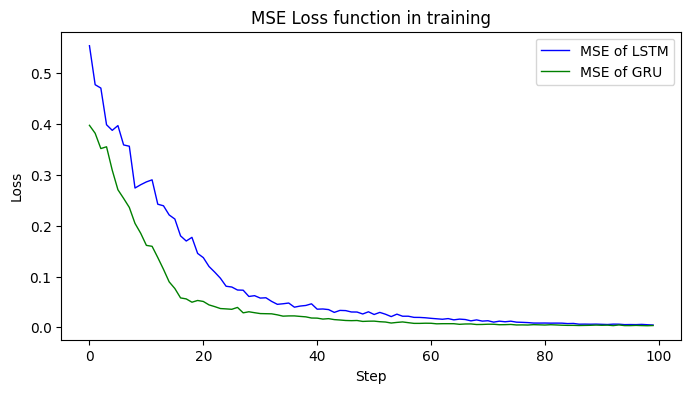

In [20]:
plt.figure(figsize=(8,4))
plt.plot(lstm_history[0], label='MSE of LSTM', linewidth='1', color='blue')
plt.plot(gru_history[0], label='MSE of GRU', linewidth='1', color='green')
plt.title('MSE Loss function in training')
plt.ylabel('Loss')
plt.xlabel('Step')
plt.legend() 
plt.show()

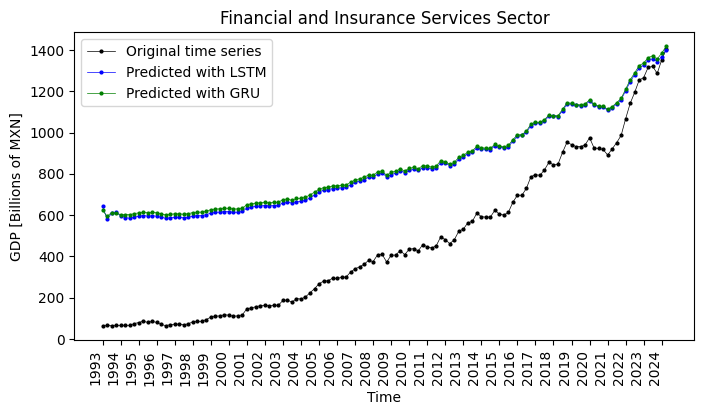

In [21]:
plt.figure(figsize=(8,4))
plt.plot(data_tensor, label='Original time series', marker='.', markersize='4', linewidth='0.5', color='black')
plt.plot(lstm_predicted, label='Predicted with LSTM', marker='.', markersize='4', linewidth='0.5', color='blue')
plt.plot(gru_predicted, label='Predicted with GRU', marker='.', markersize='4', linewidth='0.5', color='green')
plt.title('Financial and Insurance Services Sector')
plt.ylabel('GDP [Billions of MXN]')
labels, indxs = get_labels(df_data)
plt.xticks(indxs, labels, rotation=90, ha="right")
plt.xlabel('Time')
plt.legend() 
plt.show()